Requesting the GPU of Colab for faster execution

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

from tensorflow.python.client import device_lib
device_lib.list_local_devices()

Found GPU at: /device:GPU:0


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 7235242652795563847
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11320098816
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 10133984128479205976
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
 xla_global_id: 416903419]

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
7.2405064459999835
GPU (s):
0.15226051300001586
GPU speedup over CPU: 47x


Memory information available

In [ ]:
!cat /proc/meminfo

MemTotal:       13302920 kB
MemFree:         5989312 kB
MemAvailable:   11472616 kB
Buffers:          112900 kB
Cached:          4833316 kB
SwapCached:            0 kB
Active:          1853872 kB
Inactive:        5125736 kB
Active(anon):    1298200 kB
Inactive(anon):     3536 kB
Active(file):     555672 kB
Inactive(file):  5122200 kB
Unevictable:           0 kB
Mlocked:               0 kB
SwapTotal:             0 kB
SwapFree:              0 kB
Dirty:               680 kB
Writeback:             0 kB
AnonPages:       2033532 kB
Mapped:          1466984 kB
Shmem:              4276 kB
KReclaimable:      93812 kB
Slab:             148292 kB
SReclaimable:      93812 kB
SUnreclaim:        54480 kB
KernelStack:        5328 kB
PageTables:        18436 kB
NFS_Unstable:          0 kB
Bounce:                0 kB
WritebackTmp:          0 kB
CommitLimit:     6651460 kB
Committed_AS:    5153132 kB
VmallocTotal:   34359738367 kB
VmallocUsed:       46988 kB
VmallocChunk:          0 kB
Percpu:          

Installing the wandb and the dataset

In [ ]:
!pip install wandb

!wget https://storage.googleapis.com/wandb_datasets/nature_12K.zip
!unzip nature_12K.zip
!rm nature_12K.zip

--2022-03-31 17:53:24--  https://storage.googleapis.com/wandb_datasets/nature_12K.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.215.128, 173.194.216.128, 173.194.217.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.215.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3816687935 (3.6G) [application/zip]
Saving to: ‘nature_12K.zip’

nature_12K.zip      100%[===================>]   3.55G   113MB/s    in 39s     

2022-03-31 17:54:04 (92.2 MB/s) - ‘nature_12K.zip’ saved [3816687935/3816687935]

Archive:  nature_12K.zip
replace inaturalist_12K/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


Mounting Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Imports

In [ ]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Input, InputLayer, Flatten, Conv2D, BatchNormalization, MaxPooling2D, Activation , GlobalAveragePooling2D
from tensorflow.keras.models import Sequential,  Model
import tensorflow.keras.backend as K
import wandb
import tensorflow as tf
from tensorflow import keras
from sklearn import metrics
import pandas as pd
import cv2
from wandb.keras import WandbCallback
import pathlib
import seaborn as sns

Paths

In [ ]:
train_data_path = './inaturalist_12K/train'
test_data_path = './inaturalist_12K/val'
project_name = 'CS6910-Assignment2-PartA_final'
project_name_best = 'CS6910-Assignment2-PartA-bestModel_relu'
entity_name = 'cs21m007_cs21m013'
model_save_path = "./TrainedModel/"
best_model_path = "/content/drive/MyDrive/CS6910_CNN/BestModel_another_relu"
save_plots = "/content/drive/MyDrive/CS6910_CNN/"

The CNN model

In [ ]:
class cnnModel():

    '''
    Initialization of the model hyperparameters for executing the Wandb Sweep and hyperparameter tuning
    '''
    def __init__(self,img_size,model_parameters,num_classes):
        self.num_hidden_cnn_layer = model_parameters["num_hidden_cnn_layer"]
        self.activation = model_parameters["activation"]
        self.batch_normalization = model_parameters["batch_normalization"]
        self.filter_multiplier = model_parameters["filter_multiplier"]
        self.filter_size = model_parameters["filter_size"]
        self.num_filters = model_parameters["num_filters"]
        self.pool_size=model_parameters["pool_size"]
        self.dropout = model_parameters["dropout"]
        self.padding = model_parameters["padding"]
        self.optimizer = model_parameters["optimizer"]
        self.gap = model_parameters["gap"]
        self.batchnorm_location = model_parameters["batchnorm_location"]
        self.dense_neurons = model_parameters["dense_neurons"]
        self.num_classes = num_classes
        self.input_shape = (img_size[0],img_size[1],3)
        self.dropout_loc = model_parameters["dropout_loc"]


    '''
    Single CNN block including 2D Convolutional layers, Batch normalization, either before or after activation and max pooling layer
    '''
    def cnnBlock(self,model,i):
        # Standard filter distribution - same number of filters in all Convolutional layers
        if self.filter_multiplier == "standard":
            model.add(Conv2D(self.num_filters, self.filter_size,kernel_initializer = "he_uniform",padding = self.padding))
    
        # Double filter distribution - double number of filters in each Convolutional layers
        elif self.filter_multiplier == "double":
            model.add(Conv2D(2**(i+1)*self.num_filters, self.filter_size,kernel_initializer = "he_uniform", padding = self.padding))
    
        # Halve the filter size in each successive convolutional layers
        elif self.filter_multiplier == "half":
            model.add(Conv2D(int(self.num_filters/2**(i+1)), self.filter_size,kernel_initializer = "he_uniform", padding = self.padding))
    
        # Batch normalization before activation layer
        if self.batchnorm_location == "Before" and self.batch_normalization: model.add(BatchNormalization())
        model.add(Activation(self.activation))
    
        # Batch normalization after activation layer
        if self.batchnorm_location == "After" and self.batch_normalization: model.add(BatchNormalization())
    
        # Max pooling layer
        model.add(MaxPooling2D(pool_size=self.pool_size))

        return model
        

    '''
    Building the model using the CNN blocks
    '''
    def build_cnnmodel(self):
        # Including the GPU computation
        with tf.device('/device:GPU:0'):
            tf.keras.backend.clear_session()

            # Sequential model
            model = Sequential()
            
            #First CNN layer connecting to input layer
            model.add(Conv2D(self.num_filters, self.filter_size, padding = self.padding,kernel_initializer = "he_uniform", input_shape = self.input_shape))
            # Batch normalization before the activation
            if self.batchnorm_location == "Before" and self.batch_normalization: model.add(BatchNormalization())
            model.add(Activation(self.activation))
            # Batch normalization after the activation
            if self.batchnorm_location == "After" and self.batch_normalization: model.add(BatchNormalization())
            # Max pooling layer
            model.add(MaxPooling2D(pool_size=self.pool_size))  
             
            # Dropout after convolutional layers or all the layers 
            if self.dropout_loc == "conv" or self.dropout_loc=="all":
                # Checking if value is not NONE
                if self.dropout != None:
                    model.add(tf.keras.layers.Dropout(self.dropout))
                # adding the CNN blocks and the dropout after them if allowed
                for i in range(self.num_hidden_cnn_layer-1):
                    # CNN block adding
                    model = self.cnnBlock(model,i)
                    # Adding dropout
                    if self.dropout != None:
                        model.add(tf.keras.layers.Dropout(self.dropout))

            elif self.dropout_loc == "dense":
                # adding the CNN blocks and no dropout as dropout only for dense
                for i in range(self.num_hidden_cnn_layer-1):
                    model = self.cnnBlock(model,i)

            
            # Either Flattening  or Global average pooling
            if self.gap == True:
                # adding Global average pooling
                model.add(GlobalAveragePooling2D())
            else: 
                # Adding flatten layer
                model.add(Flatten())

            # Adding dropout after dense layer if dropout location is dense or all
            if self.dropout_loc == "dense" or self.dropout_loc =="all":
                # adding dense layer
                model.add(Dense(self.dense_neurons, activation = 'sigmoid'))
                if self.dropout != None:
                    # dropout layer after dense layer
                    model.add(tf.keras.layers.Dropout(self.dropout))
                # Final dens eoutput layer
                model.add(Dense(self.num_classes, activation = 'softmax'))

            # only dense followed by final out put layer and no dropout layer
            elif self.dropout_loc =="conv":
                model.add(Dense(self.dense_neurons, activation = 'sigmoid'))
                # final dense output layer
                model.add(Dense(self.num_classes, activation = 'softmax'))

            return model



Get Data

In [ ]:
'''
Function to get the training data and validation data for training
'''
def get_data(batch_size,data_augmentation,train_data_path):

    # Boolean variable specifying whether we are doing data augmentation or not
    data_augmentation = data_augmentation
    # Bactch size for training
    BATCH_SIZE = batch_size

    '''
    Performing data augemtation if true as a hyper parameter
    '''
    if data_augmentation == True:
        train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
                rescale=1./255, # rescale the images
                validation_split = 0.1, # creating the validation data from training data as 10% of training data
                shear_range=0.2, # shearing range = 0.2
                zoom_range=0.2, # zoom range = 0.2
                rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
                width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
                height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
                horizontal_flip=True,  # randomly flip images
                vertical_flip=False # Not alloewing the images to be vertically flipped
                )
    # If data augmentation is not performed, we are just generating the training data validation data as a 10% of the training data.
    else:
        train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,validation_split = 0.1)

    '''
    Generating the training data batch wise
    '''
    train_generator = train_datagen.flow_from_directory(
        train_data_path,
        subset='training',
        target_size=img_size,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle = True,
        seed = 123)
        
    '''
    Generating the validation data batch wise
    '''
    validation_generator = train_datagen.flow_from_directory(
        train_data_path,
        target_size=img_size,
        subset = 'validation',
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle = True,
        seed = 123)

    return train_generator,validation_generator

Hyperparameter values for Sweeping

In [ ]:
# input image dimensions that we are using for the following task
img_size = (128,128)

'''
Sweep config for the hyperparameter tuning
'''
sweep_config = {
  "name": "Bayesian Sweep",
  "method": "bayes",
  "metric":{
  "name": "val_accuracy", # optimizing wrt to maximizing the validation accuracy
  "goal": "maximize"
  },
  "parameters": {
        
        "activation":{
            "values": ["relu"]
        },
        "filter_size": {
            "values": [(2,2), (3,3), (4,4)]
        },
        "batch_size": {
            "values": [32, 64]
        },
        "padding": {
            "values": ["same","valid"]
        },
        "data_augmentation": {
            "values": [True, False]
        },
        "optimizer": {
            "values": ["adam", "sgd", "rmsprop"]
        },
        "batch_normalization": {
            "values": [True, False]
        },
        "batchnorm_location": {
            "values": ["After", "Before"]
        },
        "num_filters": {
            "values": [32,64, 128]
        },
        "dense_neurons": {
            "values": [64, 128, 256]
        },   
        "dropout_loc": {
            "values": ["conv","dense","all"]
        },
        "dropout": {
            "values": [None, 0.2,0.3]
        },  
        "gap": {
            "values": [False,True]
        }, 
        "filter_multiplier": {
            "values": ["standard","half","double"]
        },       
    }
}

'''
Initializing the wandb sweeps for tuning
'''
sweep_id = wandb.sweep(sweep_config,project=project_name, entity=entity_name)

Create sweep with ID: emj8ml61
Sweep URL: https://wandb.ai/cs21m007_cs21m013/CS6910-Assignment2-PartA_final/sweeps/emj8ml61


In [ ]:
'''
Training function for sweeping and hyperparameter tuning
'''
def train():
    project_name = 'CS6910-Assignment2-PartA_final'
    model_save_path = "./TrainedModel/"
    img_size=(128,128)
    #config default values for sweeping and values with only one value. 
    config_defaults = dict(
            num_hidden_cnn_layer = 5 ,
            activation = 'relu',
            batch_normalization = True,
            batchnorm_location = "After",
            filter_multiplier = "double" ,
            filter_size = (3,3),
            num_filters  = 32,
            dropout = None,
            dropout_loc = "dense",
            pool_size = (2,2),
            padding = 'same',
            dense_neurons = 128,
            num_classes = 10,
            optimizer = 'adam',
            epochs = 7,
            batch_size = 32, 
            data_augmentation = False,
            gap = True,
            img_size = img_size
        ) 

    # Initializing the wandb with project name and entity name
    wandb.init(project = project_name, config = config_defaults,entity=entity_name)
    CONFIG = wandb.config

    # Naming convention fo the wandb runs
    wandb.run.name = "Image_recog" + str(CONFIG.num_hidden_cnn_layer) + "_dn_" + str(CONFIG.dense_neurons) + "_opt_" + CONFIG.optimizer + "_dro_" + str(CONFIG.dropout) + "_bs_"+str(CONFIG.batch_size) + "_fm_" + CONFIG.filter_multiplier + "_bnl_" + CONFIG.batchnorm_location + "_dpl_" + CONFIG.dropout_loc

    with tf.device('/device:GPU:0'): 
        # Create object of the CNN model class       
        imageRecog = cnnModel(CONFIG.img_size, CONFIG, 10)
        # Build the model
        model = imageRecog.build_cnnmodel()
        
        # Printing the model summary
        model.summary()

        # Reading the data
        train_generator,validation_generator = get_data(CONFIG.batch_size,CONFIG.data_augmentation,train_data_path)

        # Model compilation
        model.compile(
        optimizer=CONFIG.optimizer,  # Optimizer
        # Loss function to minimize (categorial classification for multiclass classification)
        loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
        # Monitoring accuracy
        metrics=['accuracy'],
        )
        # Model fit for training
        history = model.fit(
                        train_generator,
                        steps_per_epoch = train_generator.samples // CONFIG.batch_size,
                        validation_data = validation_generator, 
                        validation_steps = validation_generator.samples // CONFIG.batch_size,
                        epochs = CONFIG.epochs, 
                        callbacks=[WandbCallback()]
                        )

        # Save the models in the follwoing path
        model.save(model_save_path+wandb.run.name)
        wandb.finish()
        # Returning the model and the history
        return model, history

In [ ]:
wandb.agent(sweep_id, train, count = 30)

wandb: Agent Starting Run: 13yv87by with config:
wandb: 	activation: relu
wandb: 	batch_normalization: True
wandb: 	batch_size: 32
wandb: 	batchnorm_location: Before
wandb: 	data_augmentation: False
wandb: 	dense_neurons: 64
wandb: 	dropout: 0.2
wandb: 	dropout_loc: dense
wandb: 	filter_multiplier: half
wandb: 	filter_size: [4, 4]
wandb: 	gap: True
wandb: 	num_filters: 32
wandb: 	optimizer: rmsprop
wandb: 	padding: same
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      1568      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 32)     128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 128, 128, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 16)        8208      
                                                                 
 batch_normalization_1 (Batc  (None, 64, 64, 16)       6

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


107/281 [==========>...................] - ETA: 1:05 - loss: 2.3593 - accuracy: 0.1022

Best Model

In [ ]:
!cp -rf /content/TrainedModel/Image_recog5_dn_128_opt_adam_dro_0.3_bs_64_fm_double_bnl_After_dpl_dense  /content/drive/MyDrive/CS6910_CNN/BestModel

Best Hyperparmeter values

In [ ]:
'''
Setting the hyparameter of the best configuration below for re-training the model with the best set of hyperparameters.
'''
# image size that the model is trainied on
img_size = (128,128)

# sweep config with best set of hyper parameters only for re-training
sweep_config = {
  "name": "Bayesian Sweep",
  "method": "bayes",
  "metric":{
  "name": "val_accuracy",
  "goal": "maximize"
  },
  "parameters": {
        
        "activation":{
            "values": ["elu"]
        },
        "filter_size": {
            "values": [(3,3)]
        },
        "batch_size": {
            "values": [64]
        },
        "padding": {
            "values": ["valid"]
        },
        "data_augmentation": {
            "values": [False]
        },
        "optimizer": {
            "values": ["adam"]
        },
        "batch_normalization": {
            "values": [True]
        },
        "batchnorm_location": {
            "values": ["After"]
        },
        "num_filters": {
            "values": [32]
        },
        "dense_neurons": {
            "values": [128]
        },   
        "dropout_loc": {
            "values": ["all"]
        },
        "dropout": {
            "values": [0.3]
        },  
        "gap": {
            "values": [True]
        }, 
        "filter_multiplier": {
            "values": ["double"]
        },
    }
}
# Initializing the wandb sweep for best model re-training
sweep_id = wandb.sweep(sweep_config,project=project_name_best, entity=entity_name)

Create sweep with ID: 733jcsml
Sweep URL: https://wandb.ai/cs21m007_cs21m013/CS6910-Assignment2-PartA-bestModel_relu/sweeps/733jcsml


In [ ]:
'''
Function for retraining the best model
'''
def best_train(train_data_path,model_save_path):
    project_name_best = 'CS6910-Assignment2-PartA-bestModel_relu'
    best_model_path = "/content/drive/MyDrive/CS6910_CNN/BestModel_another_relu"
    img_size=(128,128)
    config_defaults = dict(
            num_hidden_cnn_layer = 5 ,
            activation = 'relu',
            batch_normalization = True,
            batchnorm_location = "After",
            filter_multiplier = "double" ,
            filter_size = (3,3),
            num_filters  = 32,
            dropout = None,
            dropout_loc = "dense",
            pool_size = (2,2),
            padding = 'same',
            dense_neurons = 128,
            num_classes = 10,
            optimizer = 'adam',
            epochs = 8,
            batch_size = 32, 
            data_augmentation = False,
            gap = True,
            img_size = img_size
        ) 
    # wandb initializations
    wandb.init(project = project_name_best, config = config_defaults,entity=entity_name)
    CONFIG = wandb.config

    # Best model run name
    wandb.run.name = "Best_model_another"

    
    # allocating the GPU for colab
    with tf.device('/device:GPU:0'):  
        # creating object of the CNN model class      
        objDetn = cnnModel(CONFIG.img_size, CONFIG, 10)
        # calling the build CNN model function for building the model
        model = objDetn.build_cnnmodel()
        
        # returning the best model summary
        model.summary()

        # loading the train and the validation data generator
        train_generator,validation_generator = get_data(CONFIG.batch_size,CONFIG.data_augmentation,train_data_path)

        # compiling the model
        model.compile(
        optimizer=CONFIG.optimizer,  # Optimizer
        # Loss function to minimize
        loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),#'categorical_crossentropy for multiclass classification',
        # List of metrics to monitor
        metrics=['accuracy'],
        )
        
        # Model fitting
        history = model.fit(
                        train_generator,
                        steps_per_epoch = train_generator.samples // CONFIG.batch_size,
                        validation_data = validation_generator, 
                        validation_steps = validation_generator.samples // CONFIG.batch_size,
                        epochs = CONFIG.epochs, 
                        callbacks=[WandbCallback()]
                        )

        # Saving the model at the following path
        model.save(model_save_path+wandb.run.name)
        wandb.finish()
        return model, history

In [ ]:
wandb.agent(sweep_id, best_train, count=1)

accuracy,▁▂▃▃▄▄▅▆▇█
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▇▇▆▆▅▄▃▂▁
val_accuracy,▁▅▆▇▅▆██▇▅
val_loss,▅▂▁▁▂▂▁▁▃█
accuracy,0.64028
best_epoch,3
best_val_loss,1.8543
epoch,9
loss,1.04615
val_accuracy,0.28629


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 activation (Activation)     (None, 128, 128, 32)      0         
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 activation_1 (Activation)   (None, 64, 64, 64)        0

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


281/281 [==============================] - 124s 438ms/step - loss: 2.0824 - accuracy: 0.2588 - val_loss: 2.2414 - val_accuracy: 0.1935 - _timestamp: 1648730062.0000 - _runtime: 135.0000
Epoch 2/8
281/281 [==============================] - 120s 428ms/step - loss: 1.9613 - accuracy: 0.3111 - val_loss: 2.0994 - val_accuracy: 0.2802 - _timestamp: 1648730182.0000 - _runtime: 255.0000
Epoch 3/8
281/281 [==============================] - 119s 424ms/step - loss: 1.8693 - accuracy: 0.3365 - val_loss: 1.9058 - val_accuracy: 0.3286 - _timestamp: 1648730323.0000 - _runtime: 396.0000
Epoch 4/8
281/281 [==============================] - 119s 424ms/step - loss: 1.7894 - accuracy: 0.3665 - val_loss: 2.2088 - val_accuracy: 0.2883 - _timestamp: 1648730442.0000 - _runtime: 515.0000
Epoch 5/8
281/281 [==============================] - 119s 425ms/step - loss: 1.7121 - accuracy: 0.3942 - val_loss: 1.8675 - val_accuracy: 0.3508 - _timestamp: 1648730561.0000 - _runtime: 634.0000
Epoch 6/8
281/281 [===========

accuracy,▁▃▃▄▅▆▇█
epoch,▁▂▃▄▅▆▇█
loss,█▇▆▅▄▃▂▁
val_accuracy,▁▄▆▄▇▇██
val_loss,█▆▂▇▂▃▁▁
accuracy,0.50212
best_epoch,6
best_val_loss,1.83594
epoch,7
loss,1.43844
val_accuracy,0.38407


Exception: ignored

In [ ]:
!cp -rf /content/TrainedModel/Best_model_another  /content/drive/MyDrive/CS6910_CNN/BestModel_another_relu

Testing accuracy and loss

In [ ]:
'''
Function to get the test data in batches
'''
def get_test_data(batch_size,test_data_path,shuffle=True):
    # Using image data generator of keras to get test data in batches
    test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
    test_generator = test_datagen.flow_from_directory(
                test_data_path,
                target_size=(img_width,img_height),
                batch_size=batch_size,
                class_mode='categorical',
                shuffle = True, seed=1234)
    
    return test_generator

In [ ]:
img_width,img_height = 128,128
batch_size=32

# Loading the best model
best_model = keras.models.load_model(best_model_path) #Load the best trained model
best_model.summary()

# Load the test data in batches for evaluation
test_generator = get_test_data(batch_size,test_data_path)
            
#Test loss and accuracy on the shuffled test dataset            
history = best_model.evaluate(test_generator)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 activation (Activation)     (None, 128, 128, 32)      0         
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 activation_1 (Activation)   (None, 64, 64, 64)        0

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


63/63 [==============================] - 28s 440ms/step - loss: 1.8275 - accuracy: 0.3740


Confusion Matrix on the test data

Found 2000 images belonging to 10 classes.


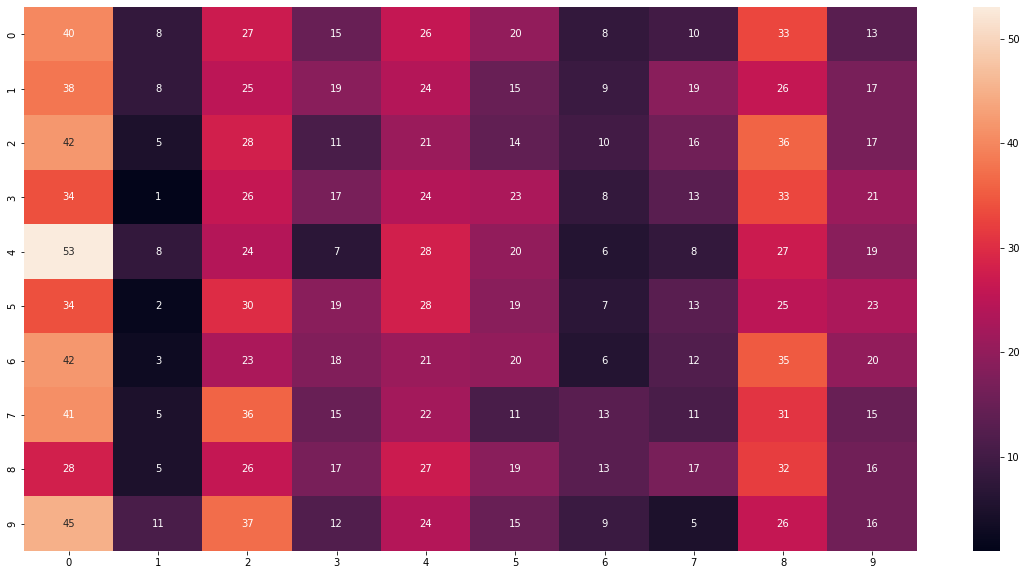

In [ ]:
# image sizes
img_width,img_height = 128,128
# Batch size
batch_size=32
# Load the test data
test_generator = get_test_data(batch_size,test_data_path,shuffle = False)

# Loading the best model
source_model = keras.models.load_model(best_model_path) #Load the best trained model
# prediction labels
pred_labels = source_model.predict(test_generator)
pred_labels_num = np.argmax(pred_labels, axis = 1)
# Confusion matrix
cm = metrics.confusion_matrix(test_generator.classes, np.argmax(pred_labels, axis = 1))
# plot the figure
plt.figure(figsize=(20,10)) 
# using heatmap for the confusion matrix
sns.heatmap(cm, annot=True)
plt.savefig(save_plots+"Confusion_matrix")
# Display the confusion matrix
plt.show()

Found 2000 images belonging to 10 classes.


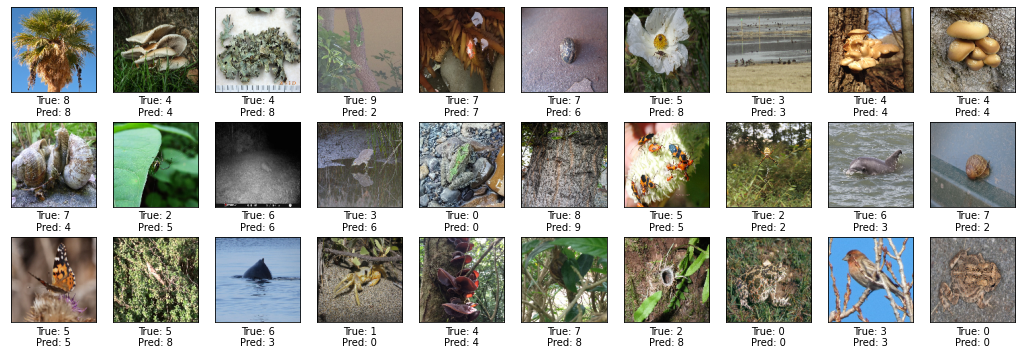

In [ ]:
#To let the gpu memory utilisiation grow as per requirement
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
#Invalid device or cannot modify virtual devices once initialized.
    pass
# The dimensions of our input image
img_width,img_height = 128, 128
# Batch size
batch_size=32
wandb.init(project = "partA_plots", entity='cs21m007_cs21m013')
# Load the test data
test_generator = get_test_data(batch_size,test_data_path,shuffle=False)

#Model trained from scratch
source_model = keras.models.load_model(best_model_path) #Load the best trained model


# Sample image predictions
ROWS = 3
COLUMNS = 10 
ix = 1 
fig,ax = plt.subplots(ROWS,COLUMNS,figsize=(6*ROWS,6))
for i in range(ROWS): 
    for j in range(COLUMNS): 
        # Creating the subplots for the sample images
        idx = np.random.choice(len(test_generator[4*j][0])) 
        img = test_generator[4*j][0][idx] 
        ax = plt.subplot(ROWS, COLUMNS, ix) 

        ax.set_xticks([]) 
        ax.set_yticks([])
        # Creating the images of the subplots 
        plt.imshow(img) 
        plt.xlabel(
                    "True: " + str(np.argmax(test_generator[4*j][1][idx])) +"\n" + "Pred: " + 
                    str(np.argmax(source_model.predict(img.reshape(1,128,128,3))))
                   )     
        ix += 1 
# Save the images
plt.savefig(save_plots+"sample_prediction")
wandb.log({"sample_prediction": plt})
plt.show()

Filter Visulaizations


Found 2000 images belonging to 10 classes.


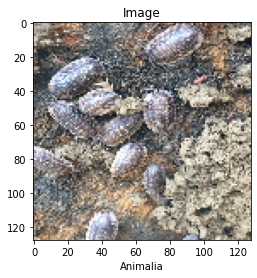

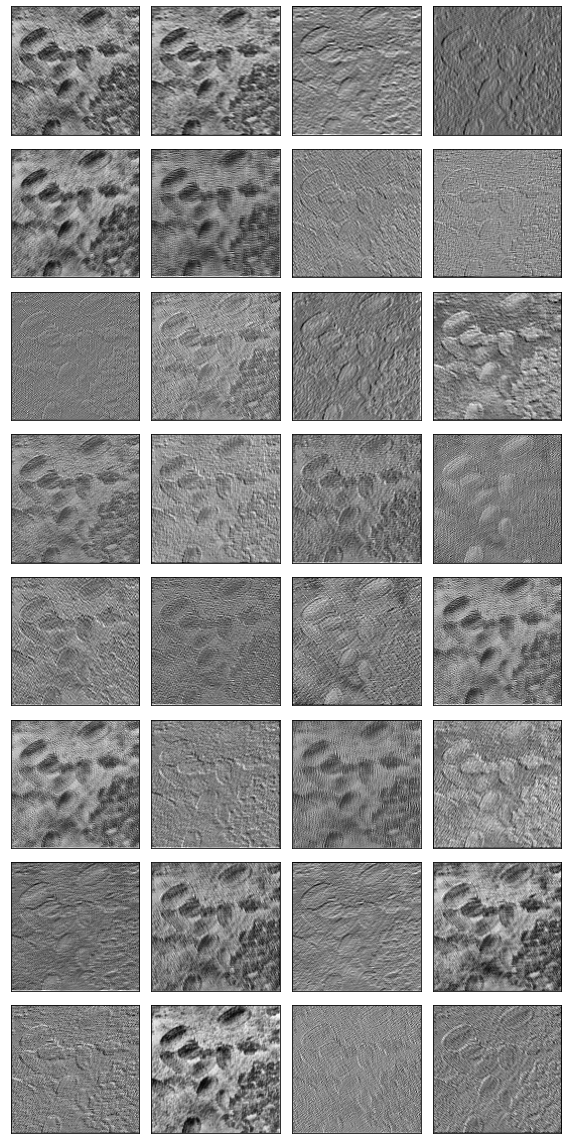

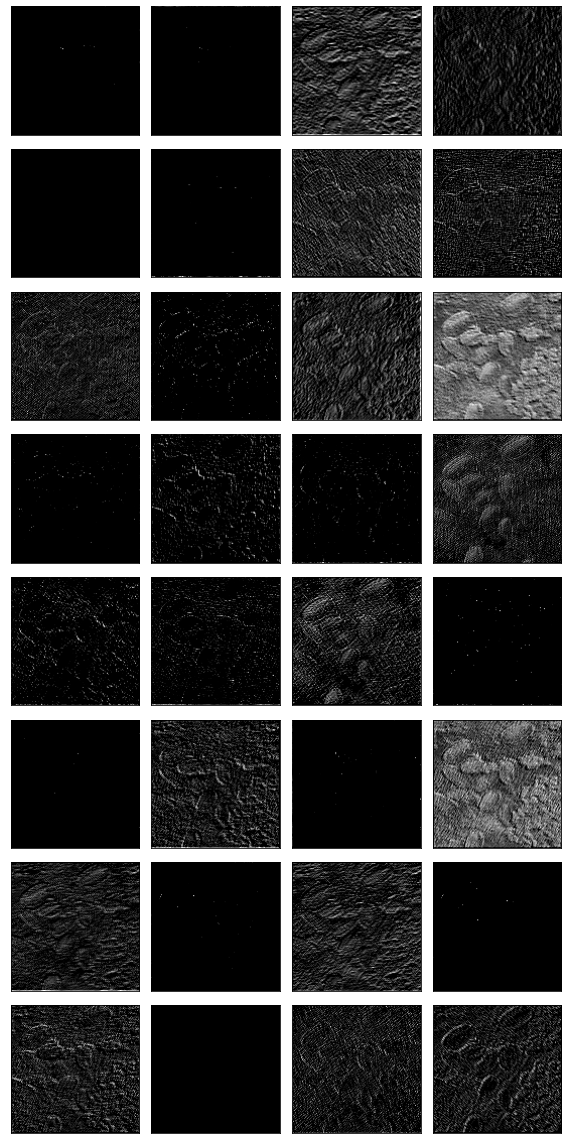

In [ ]:

#To let the gpu memory utilisiation grow as per requirement
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
#Invalid device or cannot modify virtual devices once initialized.
    pass

'''
plotting the subplots for the filter visualizations
'''
def plot_maps(feature_maps,ROWS,COLUMNS,savePath,name):
		wandb.init(project = "partA_plots", entity='cs21m007_cs21m013')
		ROWS = ROWS
		COLUMNS = COLUMNS 
		ix = 1
		fig,ax = plt.subplots(ROWS,COLUMNS,figsize=(ROWS,4*COLUMNS))
		for _ in range(ROWS):
			for _ in range(COLUMNS):
				# specify subplot and turn of axis
				ax = plt.subplot(ROWS, COLUMNS, ix)
				ax.set_xticks([])
				ax.set_yticks([])
				# plot filter channel in grayscale
				plt.imshow(feature_maps[0, :, :, ix-1],cmap="gray")
				ix += 1
		# show the figure
		plt.tight_layout()
		plt.savefig(savePath)
		wandb.log({name: plt})
		plt.show()

'''
Function to return the class names
'''
def class_names(DATAPATH):
    # Return the list of the class names
		class_name=[]
		for dir1 in np.sort(os.listdir(DATAPATH)):
				class_name.append(dir1)
		return class_name



class_names = class_names(test_data_path)
target_dict = {k: v for v, k in enumerate(np.unique(class_names))} 
class_label_names_dict = {str(k): v for k, v in enumerate(np.unique(class_names))} 
# The dimensions of our input image

img_width,img_height = 128, 128
batch_size=32

test_generator = get_test_data(batch_size,test_data_path,shuffle=False)

# Loading the best model
source_model = keras.models.load_model(best_model_path) #Load the best trained model

#1st Convolutional layer:
layer_name = "conv2d"  # convolutional layer
activation_layer_name = "activation" # Activation layer

# get the layer
layer = source_model.get_layer(name=layer_name)
# get the activation layer
activation_layer = source_model.get_layer(name=activation_layer_name)

# Extract features from the 1st convo-layer
feature_extractor = keras.Model(inputs=source_model.inputs, outputs=layer.output)
# Extract features from the 1st activation layer
feature_extractor_activation = keras.Model(inputs=source_model.inputs, outputs=activation_layer.output)

# get the filters and the biases (weights)
filters, biases = layer.get_weights()


# normalize filter values to 0-1 so we can visualize them
filter_min, filter_max = filters.min(), filters.max()
filters = (filters - filter_min) / (filter_max - filter_min)

# Create a random batch of images
batch = np.random.choice(int(2000/32))
img_index = 10    
# get a random image
img = test_generator[batch][0][img_index]
img = np.expand_dims(img, axis = 0)
# Get the label of the random image
img_true_label = test_generator[batch][1][img_index]

'''plot the test image:'''
plt.figure()
plt.xlabel(class_label_names_dict[str(np.argmax(img_true_label))])
plt.imshow(img[0])
plt.title("Image")
plt.savefig(save_plots+"Image")
wandb.init(project = "partA_plots", entity='cs21m007_cs21m013')
wandb.log({"Test_Image": plt})
plt.show()



#Extract the feature maps and feature activation maps
feature_maps = feature_extractor(img) 
feature_maps_activation = feature_extractor_activation(img) 

#64 filters in the first layer of the Best model:
ROWS = 8
COLUMNS = 4
plot_maps(feature_maps,ROWS,COLUMNS,save_plots+"Feature_map","Feature_map")

ROWS = 8
COLUMNS = 4
plot_maps(feature_maps_activation,ROWS,COLUMNS,save_plots+"activation_maps","activation_maps")

Guided Backprop

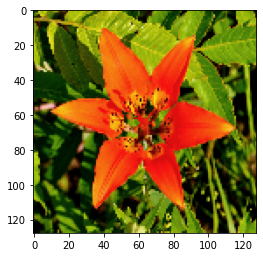

In [ ]:
plt.figure(figsize=(4, 6))
num_sample_images=10
sample_imgs = tf.convert_to_tensor(test_generator[0][0][:num_sample_images], dtype=tf.float32)
sample_img_labels = np.array([np.argmax(test_generator[0][1][i]) for i in range(num_sample_images)])
wandb.init(project = "partA_plots", entity='cs21m007_cs21m013')
plt.savefig(save_plots+"guided_image")
plt.imshow(sample_imgs[0])
wandb.log({"Guided_test_image": plt})
plt.show()

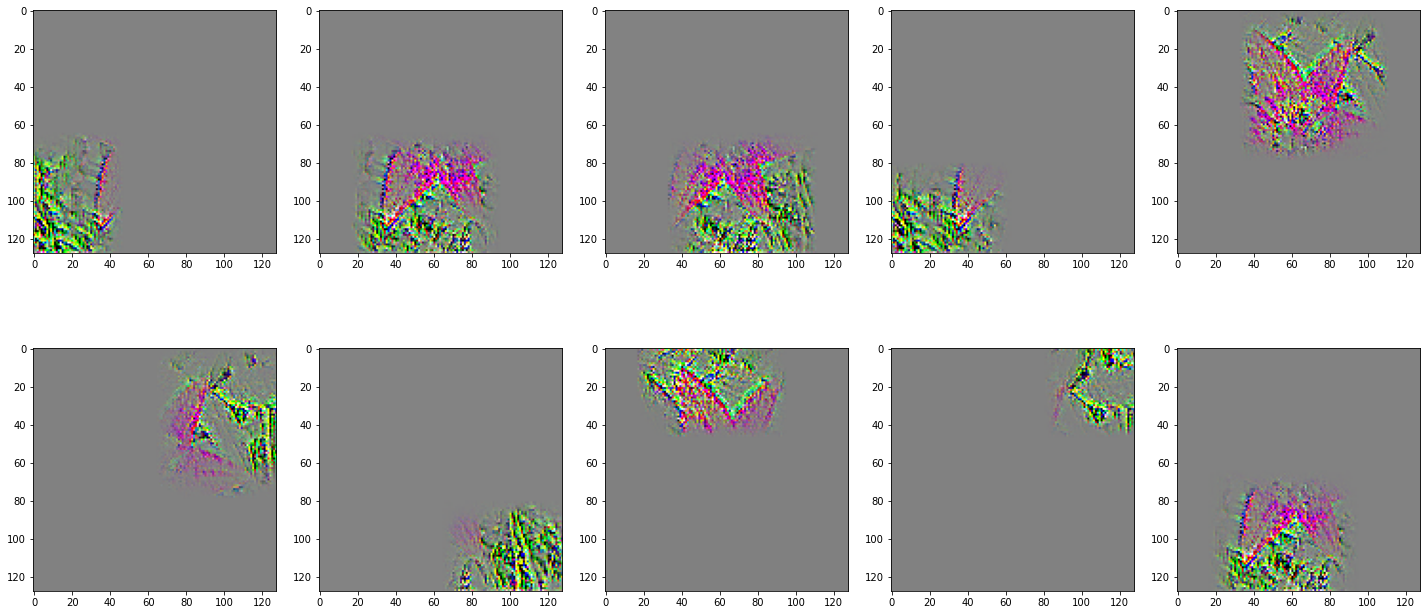

(<keras.engine.sequential.Sequential at 0x7fdf58510fd0>,
 <keras.engine.functional.Functional at 0x7fdf3fd3d490>)

In [ ]:
#To let the gpu memory utilisiation grow as per requirement
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
#Invalid device or cannot modify virtual devices once initialized.
    pass

#Default image size:
IMG_SIZE = (128, 128)
DATAPATH = test_data_path
MODELPATH = best_model_path
convo_layer = "conv2d_4"
'''
Function to process the image
'''  
def deprocess_image(img):
    img = img.copy()
    # Zero centering the image (subtracting the mean and dividing by the standard deviation)
    img -= img.mean()
    img /= (img.std() + K.epsilon())
    img *= 0.25

    # clip to [0, 1]
    img += 0.5
    # clip the images between 0 and 1
    img = np.clip(img, 0, 1)

    # convert the image to RGB array
    img *= 255
    if K.image_data_format() == 'channels_first':
        img = img.transpose((1, 2, 0))
    img = np.clip(img, 0, 255).astype('uint8')
    return img
 
#Custom gradient function for guided backpropagation. Consists of guided relu function and its gradient.        
'''
Guided Relu function and its derievative for back propagation
'''
@tf.custom_gradient
def guidedRelu(x):
  def derieve(dy):
    # Gradient and the derievative if the Relu function
    return tf.cast(dy>0,"float32") * tf.cast(x>0, "float32") * dy
  # Return the relu if derievative is not true
  return tf.nn.relu(x), derieve

# Guided backpropagation on multiple images:
#------------------------------------------#

def guided_backpropagation(MODELPATH, num_sample_images = 10):
    
    # loading the best model
    model = tf.keras.models.load_model(MODELPATH)

    # guided backpropagated model
    gb_model = Model(
        inputs = [model.inputs],
        outputs = [model.get_layer(convo_layer).output]
    )
    # if layer as activation and if its is relu activation then do the follwing   
    for layer in model.layers:
        if hasattr(layer, 'activation') and layer.activation==tf.keras.activations.relu:
            layer.activation = guidedRelu

    '''
    plotting the images
    '''
    # Subplot for the images
    #fig, ax = plt.subplots(1, 10, figsize=(3*8, 3))
    # subplot for the gradient visualizations
    #fig1, ax1 = plt.subplots(1, num_sample_images, figsize=(3*8, 3))
    sample_imgs = tf.convert_to_tensor(test_generator[0][0][:num_sample_images], dtype=tf.float32)
    sample_img_labels = np.array([np.argmax(test_generator[0][1][i]) for i in range(num_sample_images)])
    conv_output_shape = model.get_layer(convo_layer).output.shape[1:]
    #plt.imshow(sample_imgs[0])
    plt.figure(figsize=(20, 10))
    #plt.set_label(str(sample_img_labels[0]))
    for i in range(10):
        node_x = np.random.randint(0, conv_output_shape[0])

        node_y = np.random.randint(0, conv_output_shape[1])

        node_z = np.random.randint(0, conv_output_shape[2])

        # Focus on single neuron of the conv layer (mask for this)
        mask = np.zeros((1, *conv_output_shape), dtype="float")
        mask[0, node_x, node_y, node_z] = 1
        with tf.GradientTape() as tape:
            inputs = tf.cast(np.array([np.array(sample_imgs[0])]), tf.float32)
            tape.watch(inputs)
            outputs = gb_model(inputs) * mask

        # obtain the gradient
        gradients = tape.gradient(outputs,inputs)[0]
        # Display the image
        # Display the gradient visualizations by de processing the image into RGB image for displaying
        #ax1[i].imshow(deprocess_image(np.array(gradients)))
        #ax1[i].set_xlabel(str(sample_img_labels[i]))
        #grads = tape.gradient(outputs, inputs)[0]
        # Visualize the output of guided backpropagation
        img_gb = np.dstack((gradients[:, :, 0], gradients[:, :, 1], gradients[:, :, 2],)) 
        plt.subplot(2, 5, i+1)
        plt.imshow(deprocess_image(img_gb))
    #fig.savefig(save_plots+"guided_images")
    #fig1.savefig(save_plots+"guided_backprop")   
    plt.tight_layout() 
    plt.savefig(save_plots+"guided_backprop")
    plt.show()

    return model, gb_model

#Just to visualise the backpropagated gradients on multiple sample images:
guided_backpropagation(MODELPATH)